In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import gdown
import io
import pandas as pd

from google.colab import files
from tensorflow import keras
from keras import layers
from keras.datasets import fashion_mnist
from keras import initializers

!pip install transformers
from transformers import pipeline
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification




Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 55.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 71.9 MB/s eta 0:00:00


# Завдання машинного перекладу.

In [ ]:
uploaded = files.upload()

Saving ukr.txt to ukr.txt


In [ ]:
lines= pd.read_table(io.BytesIO(uploaded['ukr.txt']),  names =['source', 'target', 'comments'])
lines.head()

,source,target,comments
0,Go.,Йди.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
1,Hi.,Вітаю!,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
2,Hi.,Привіт.,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
3,Hi.,Привіт!,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
4,Run!,Біжіть!,CC-BY 2.0 (France) Attribution: tatoeba.org #9...


In [ ]:
batch_size = 64 
epochs = 100  
latent_dim = 256 
num_samples = 10000

In [ ]:
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()

lines = uploaded['ukr.txt'].decode("utf-8").split("\n")
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text, _ = line.split("\t")
    target_text = "\t" + target_text + "\n"
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print("Samples:", len(input_texts))
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)

input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros((len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype="float32")

decoder_input_data = np.zeros((len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32")

decoder_target_data = np.zeros((len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32")

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.0
    encoder_input_data[i, t + 1 :, input_token_index[' ']] = 1.0
    for t, char in enumerate(target_text):
        decoder_input_data[i, t, target_token_index[char]] = 1.0
        if t > 0:
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.0

Samples: 10000
Max sequence length for inputs: 15
Max sequence length for outputs: 54


In [ ]:
encoder_inputs = keras.Input(shape=(None, num_encoder_tokens))
encoder = keras.layers.LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

encoder_states = [state_h, state_c]
decoder_inputs = keras.Input(shape=(None, num_decoder_tokens))

decoder_lstm = keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = keras.layers.Dense(num_decoder_tokens, activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)

model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [ ]:
model.compile(
    optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"]
)
model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,
)
model.save("s2s")

Epoch 1/100
125/125 [==============================] - 10s 19ms/step - loss: 0.9625 - accuracy: 0.0343 - val_loss: 1.0175 - val_accuracy: 0.0371
Epoch 2/100
125/125 [==============================] - 1s 11ms/step - loss: 0.9036 - accuracy: 0.0461 - val_loss: 0.9605 - val_accuracy: 0.0567
Epoch 3/100
125/125 [==============================] - 1s 11ms/step - loss: 0.8629 - accuracy: 0.0567 - val_loss: 0.9326 - val_accuracy: 0.0639
Epoch 4/100
125/125 [==============================] - 1s 11ms/step - loss: 0.8319 - accuracy: 0.0644 - val_loss: 0.8917 - val_accuracy: 0.0716
Epoch 5/100
125/125 [==============================] - 1s 11ms/step - loss: 0.8097 - accuracy: 0.0697 - val_loss: 0.8757 - val_accuracy: 0.0757
Epoch 6/100
125/125 [==============================] - 1s 11ms/step - loss: 0.7917 - accuracy: 0.0734 - val_loss: 0.8532 - val_accuracy: 0.0812
Epoch 7/100
125/125 [==============================] - 1s 11ms/step - loss: 0.7728 - accuracy: 0.0773 - val_loss: 0.8397 - val_accuracy

In [ ]:
model = keras.models.load_model("s2s")

encoder_inputs = model.input[0]
encoder_outputs, state_h_enc, state_c_enc = model.layers[2].output  # lstm_1
encoder_states = [state_h_enc, state_c_enc]
encoder_model = keras.Model(encoder_inputs, encoder_states)

decoder_inputs = model.input[1]
decoder_state_input_h = keras.Input(shape=(latent_dim,))
decoder_state_input_c = keras.Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_lstm = model.layers[3]
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs
)
decoder_states = [state_h_dec, state_c_dec]
decoder_dense = model.layers[4]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = keras.Model(
    [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
)

reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())


def decode_sequence(input_seq):
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    target_seq[0, 0, target_token_index["\t"]] = 1.0

    stop_condition = False
    decoded_sentence = ""
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        if sampled_char == "\n" or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True

        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.0

        states_value = [h, c]
    return decoded_sentence

In [ ]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, tf.newaxis, :], dtype="int32")
        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super(PositionalEmbedding, self).__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)


class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(latent_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs, value=inputs, key=inputs, attention_mask=causal_mask
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)

In [ ]:
for seq_index in range(0,1000,25):
    input_seq = encoder_input_data[seq_index : seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print("Input sentence:", input_texts[seq_index])
    print("Decoded sentence:", decoded_sentence)

1/1 [==============================] - 0s 31ms/step
Input sentence: Go.
Decoded sentence: Дів.

1/1 [==============================] - 0s 22ms/step
Input sentence: Do it.
Decoded sentence: Зроби це.

1/1 [==============================] - 0s 15ms/step
Input sentence: Eat it.
Decoded sentence: Зачекай.

1/1 [==============================] - 0s 18ms/step
Input sentence: I paid.
Decoded sentence: Я заплатив.

1/1 [==============================] - 0s 16ms/step
Input sentence: Thanks!
Decoded sentence: Дякую.

1/1 [==============================] - 0s 16ms/step
Input sentence: Be fair.
Decoded sentence: Будь переберий.

1/1 [==============================] - 0s 16ms/step
Input sentence: Get out.
Decoded sentence: Йди звідний.

1/1 [==============================] - 0s 16ms/step
Input sentence: Help me!
Decoded sentence: Допоможи мене.

1/1 [==============================] - 0s 19ms/step
Input sentence: I cried.
Decoded sentence: Я заплакав.

1/1 [==============================] - 0s 16ms/

# Генерація зображень.

In [ ]:
np.random.seed(1000)

In [ ]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
print(x_train.shape[0], 'train samples')
print('Image shape: ', x_train[0].shape)

4422102/4422102 [==============================] - 0s 0us/step
60000 train samples
Image shape:  (28, 28)


In [ ]:
input_dim = 784
x_train = x_train.reshape(60000, input_dim)
print('Input shape: ', x_train.shape[1])
x_train = (x_train.astype(np.float32) - 127.5) / 127.5

Input shape:  784


In [ ]:
optim = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

In [ ]:
def build_discriminator():
    model =  keras.Sequential()
    model.add(layers.Dense(1024, input_dim=input_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))
        
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Dense(256))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))
        
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optim)
    return model

def build_generator():
    model =  keras.Sequential()
    model.add(layers.Dense(256, input_dim=latent_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    model.add(layers.Dense(1024))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    model.add(layers.Dense(input_dim, activation='tanh'))
    model.compile(loss='binary_crossentropy', optimizer=optim)
    return model 

In [ ]:
latent_dim = 100
discriminator = build_discriminator()
generator = build_generator()

discriminator.trainable = False
gan_input = keras.Input(shape=(latent_dim,))
x = generator(gan_input)
gan_output = discriminator(x)
gan = keras.Model(inputs=gan_input, outputs=gan_output)
gan.compile(loss='binary_crossentropy', optimizer=optim) 

In [ ]:
def plot_generated_images(epoch, generator):
    num_of_images = 10
    noise = np.random.normal(0, 1, size=[num_of_images, latent_dim])
    generated_images=generator.predict(noise).reshape(num_of_images, 28, 28)
    plt.figure()
    for i in range(num_of_images):
        plt.subplot(1, 10, i+1)
        plt.imshow(generated_images[i], cmap = 'gray')
        plt.axis('off')
        plt.tight_layout()
    plt.show()

In [ ]:
discrim_losses = []

def train_model(epochs, batch_size):
    num_batches = int(x_train.shape[0]/batch_size)
    for ep in range(epochs+1):
        for i in range(num_batches):
            noise = np.random.normal(0, 1, size=[batch_size, latent_dim])
            image_batch = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]
            
            
            generated_images = generator.predict(noise)
            X = np.concatenate([image_batch, generated_images])

            
            y_dis = np.zeros(2*batch_size)
            y_dis[:batch_size] = 0.9  
            
            discriminator.trainable = True
            d_loss = discriminator.train_on_batch(X, y_dis)
            discrim_losses.append(d_loss)

            
            noise = np.random.normal(0, 1, size=[batch_size, latent_dim])
            y_gen = np.ones(batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y_gen)
        if ep % 20 == 0:
            print('epoch: ', ep)
            plot_generated_images(ep, generator)

4/4 [==============================] - 0s 3ms/step
epoch:  0
1/1 [==============================] - 0s 60ms/step


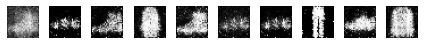

Streaming output truncated to the last 5000 lines.
4/4 [==============================] - 0s 5ms/step
epoch:  20
1/1 [==============================] - 0s 14ms/step


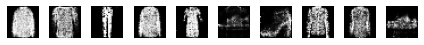

Streaming output truncated to the last 5000 lines.
4/4 [==============================] - 0s 6ms/step
epoch:  40
1/1 [==============================] - 0s 29ms/step


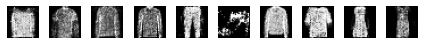

Streaming output truncated to the last 5000 lines.
4/4 [==============================] - 0s 4ms/step
epoch:  60
1/1 [==============================] - 0s 20ms/step


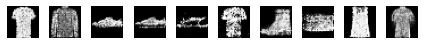

Показано результат, скорочений до останніх рядків (5000).
4/4 [==============================] - 0s 3ms/step
epoch:  80
1/1 [==============================] - 0s 20ms/step


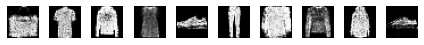

Показано результат, скорочений до останніх рядків (5000).
4/4 [==============================] - 0s 4ms/step
epoch:  100
1/1 [==============================] - 0s 44ms/step


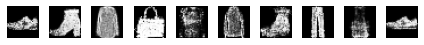

In [13]:
epochs = 100
batch_size = 128
train_model(epochs, batch_size)

# Експерименти з моделями бібліотеки HF Transformers.

In [3]:
classifier = pipeline('sentiment-analysis')

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [ ]:
txt_1 = 'Ukraine is the capital of great people.'
classifier(txt_1)

[{'label': 'POSITIVE', 'score': 0.9998270869255066}]

In [ ]:
txt_2 = 'The weather is rainy today.'
classifier(txt_2)

[{'label': 'NEGATIVE', 'score': 0.9916325211524963}]

In [ ]:
nlp_qa = pipeline('question-answering')
nlp_qa(context='Oleg lives in Kyiv.', question='Where does Oleg live?')

No model was supplied, defaulted to distilbert-base-cased-distilled-squad and revision 626af31 (https://huggingface.co/distilbert-base-cased-distilled-squad).
Using a pipeline without specifying a model name and revision in production is not recommended.


{'score': 0.9799548387527466, 'start': 14, 'end': 18, 'answer': 'Kyiv'}

In [ ]:
uploaded = files.upload()

Saving dog.jpg to dog (1).jpg


In [ ]:
question = "Where is the dog?"
vqa = pipeline(task="vqa")
preds = vqa(image='dog.jpg', question=question)
preds = [{"score": round(pred["score"], 4), "answer": pred["answer"]} for pred in preds]
preds

No model was supplied, defaulted to dandelin/vilt-b32-finetuned-vqa and revision 4355f59 (https://huggingface.co/dandelin/vilt-b32-finetuned-vqa).
Using a pipeline without specifying a model name and revision in production is not recommended.


[{'score': 0.9834, 'answer': 'beach'},
 {'score': 0.5173, 'answer': 'on beach'},
 {'score': 0.1099, 'answer': 'sand'},
 {'score': 0.0089, 'answer': 'yes'},
 {'score': 0.0051, 'answer': 'outside'}]

In [ ]:
model = TFAutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased-finetuned-sst-2-english')
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased-finetuned-sst-2-english')

Some layers from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english and are newly initialized: ['dropout_45']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
inputs = tokenizer([txt_1, txt_2])
inputs

{'input_ids': [[101, 5924, 2003, 1996, 3007, 1997, 2307, 2111, 1012, 102], [101, 1996, 4633, 2003, 16373, 2651, 1012, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1]]}

In [ ]:
inputs_with_padding = tokenizer([txt_1, txt_2], padding = True, truncation = True, max_length = 256, return_tensors="tf")
inputs_with_padding

{'input_ids': <tf.Tensor: shape=(2, 10), dtype=int32, numpy=
array([[  101,  5924,  2003,  1996,  3007,  1997,  2307,  2111,  1012,
          102],
       [  101,  1996,  4633,  2003, 16373,  2651,  1012,   102,     0,
            0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(2, 10), dtype=int32, numpy=
array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 0, 0]], dtype=int32)>}

In [ ]:
outputs = model(inputs_with_padding)
outputs

TFSequenceClassifierOutput(loss=None, logits=<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[-4.176362 ,  4.4861693],
       [ 2.6187186, -2.156284 ]], dtype=float32)>, hidden_states=None, attentions=None)

In [ ]:
predictions = tf.nn.softmax(outputs[0], axis=-1)
predictions

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[1.7291614e-04, 9.9982709e-01],
       [9.9163252e-01, 8.3674574e-03]], dtype=float32)>